### ViT
Step by step detail (https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632)<br>
[code](https://github.com/FrancescoSaverioZuppichini/ViT/blob/main/README.ipynb)

In [52]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

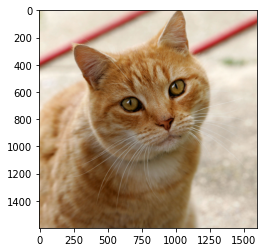

In [22]:
img = Image.open('./images/Cat03.jpg')
fig = plt.figure()
plt.imshow(img)

In [23]:
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dim
x.shape

torch.Size([1, 3, 224, 224])

### einops rearrange

In [24]:
patch_size = 16 # 16 pixels
pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)

<img src="./images/encoder.png" style="height:400px"/>

### PatchEmbedding

In [33]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        
        # basic one using linear
#         self.projection = nn.Sequential(
#             # break-down the image in s1 x s2 patches and flat them
#             Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
#             nn.Linear(patch_size * patch_size * in_channels, emb_size)
#         )
        # using a conv layer instead of a linear one -> performance gains
        self.projection = nn.Sequential(
            # using a kernel_size and stride equal to the patch_size. 
            # Intuitively, the convolution operation is applied to each patch individually. 
            # So, we have to first apply the conv layer and then flat the resulting images.
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'), # e = embedding size
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

### Multi-Head Attention

In [34]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        self.scaling = (self.emb_size // num_heads) ** -0.5

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        # sum up over the last axis (I think it's inner product with KEY.T)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        att = F.softmax(energy, dim=-1) * self.scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

### Residuals

In [35]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

### MLP

In [37]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

### Transformer Encoder

In [40]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
        ))
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

In [41]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

### Classification Head

In [42]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

<img src="./images/ViT.png" />

In [54]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
# model = ViT(img_size=28, 
#             patch_size=7, 
#             n_classes=10, 
#             in_channels=1,
#             emb_size=64,
#             depth=6, 
#             num_heads=8).to(device)

            # TransformerEncoderBlock
#             drop_p: float = 0.,
#             forward_expansion: int = 4,
#             forward_drop_p: float = 0.,
            # FeedForwardBlock
#             emb_size, 
#             expansion=forward_expansion, 
#             drop_p=forward_drop_p
            # MultiHeadAttention
#             emb_size: int = 768, 
#             num_heads: int = 8, 
#             dropout: float = 0

In [64]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = F.log_softmax(model(data), dim=1)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [65]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../../../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../../../data', train=False,
                   transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64, num_workers=1, pin_memory=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=64, num_workers=1, pin_memory=True, shuffle=True)

model = ViT(img_size=28, 
            patch_size=7, 
            n_classes=10, 
            in_channels=1,
            emb_size=64,
            depth=6, 
            num_heads=8).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.003)
# model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1)

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(1, 10 + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)
    scheduler.step()

# if args.save_model:
#     torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.461796
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.530978
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.462788
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.166544
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.095056
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.124574
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.040354
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.221133
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.185436
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.075113

Test set: Average loss: 0.1246, Accuracy: 9614/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.147904
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.092371
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.060835
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.085924
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.010614
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.058863
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.068209
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.015650
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.112706
T

In [63]:
summary(model, (1, 28, 28), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]           3,200
         Rearrange-2               [-1, 16, 64]               0
    PatchEmbedding-3               [-1, 17, 64]               0
         LayerNorm-4               [-1, 17, 64]             128
            Linear-5               [-1, 17, 64]           4,160
            Linear-6               [-1, 17, 64]           4,160
            Linear-7               [-1, 17, 64]           4,160
           Dropout-8            [-1, 8, 17, 17]               0
            Linear-9               [-1, 17, 64]           4,160
MultiHeadAttention-10               [-1, 17, 64]               0
          Dropout-11               [-1, 17, 64]               0
      ResidualAdd-12               [-1, 17, 64]               0
        LayerNorm-13               [-1, 17, 64]             128
           Linear-14              [-1,